In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso
from tqdm.auto import tqdm

plt.style.use('ggplot')

/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# This script is evaluating how different alpha values affect BIC and sparsity of precision matrix (this is on original unbootstrapped data)

No bootstrapping on this either so will need to combine into one notebook

Something about the a4 datasets is making this ill coniditoned for the solver/breaking figure it out
adni data seems fine tho 

In [2]:
data = pd.read_csv("../../data_paths_and_cleaning/data/final_cleaned_quartiles/adni_quartiles/adni_amy_tau_merged_cent_high_quartile.csv",index_col=0)
data.sample(3)

,SUPRAMARGINAL,AMYGDALA,MIDDLETEMPORAL,PARSOPERCULARIS,CAUDALANTERIORCINGULATE,INSULA,MEDIALORBITOFRONTAL,ENTORHINAL,PUTAMEN,PERICALCARINE,...,POSTERIORCINGULATE,SUPERIORTEMPORAL,FUSIFORM,PARACENTRAL,CEREBELLUM_CORTEX,PARAHIPPOCAMPAL,BANKSSTS,POSTCENTRAL,HIPPOCAMPUS,SUPERIORFRONTAL
RID,,,,,,,,,,,,,,,,,,,,,
6809,1.176,1.367,1.250,1.114,0.860,0.969,0.988,1.271,1.636,0.667,...,0.880,1.013,1.219,1.003,0.966,1.179,0.879,0.932,1.138,0.979
4278,1.309,2.491,1.763,1.193,1.121,1.278,1.236,1.870,1.730,1.217,...,1.169,1.300,1.476,1.049,1.044,1.552,1.421,1.093,1.548,1.162
4659,1.367,1.303,1.296,1.245,1.029,1.115,1.094,1.479,1.691,0.842,...,1.135,1.233,1.262,1.131,1.012,1.175,1.200,1.189,1.177,1.190


In [3]:
# #for instance figure out exactly what data I want to do this on (both these versions have hippocampus)
# data = pd.read_csv("construct_ggm/pet_graphs/a4/a4_amy_tau_merged_cent_low_quartile.csv",index_col=0)
# data.sample(3)

In [4]:
print(data["CENTILOIDS"])

RID
555     114.0
626     123.0
731     157.0
800     121.0
2068    133.0
        ...  
6512    138.0
6535    139.0
6572    115.0
6580    142.0
7105    112.0
Name: CENTILOIDS, Length: 99, dtype: float64


In [5]:
#drop centiloids
data = data.drop(columns="CENTILOIDS")

In [6]:
# data = pd.read_csv("construct_ggm/pet_graphs/amy_pos_reg_dropleftright.csv",index_col=0)
# data.sample(3)

In [7]:
scaler = StandardScaler()
scaler.set_output(transform='pandas')

data_scaled = scaler.fit_transform(data)

### Graphical Lasso Model
- 

In [8]:
model = GraphicalLasso(alpha=0.6, 
                       max_iter=100, 
                       tol=1e-2, 
                       mode='cd',
                       assume_centered=True)

model.fit(data_scaled)

GraphicalLasso(alpha=0.6, assume_centered=True, tol=0.01)

### Analyze how the graphical lasso model behaves with different regularization strengths (alpha values)
- the regularization (alpha) paramter affects the sparsity of the precision and covariance matrices 
- the number of nonzero elements gives an inishgt into how many conditional depnedencies are present at different alpha values

In [9]:
#generating a sequence of 128 alpha values evenly spaces between .05 and 1 
#testing out different strengths of regularization parameter alpha for the graphical lasso model
alphas = np.linspace(0.05,1.,128)

#initializing lists to store precision matrix, covariance matrix, and log-liklihoods 
#looking at each metric for model fits with different alpha values 
precision_nonzero = []
covariance_nonzero = []
#log liklihood can be used to asses the fit of the model at each alpha value 
log_likelihoods = []

n_features = len(data_scaled.columns)
n_samples = len(data_scaled)

#iterate through each alpha value
for alpha in tqdm(alphas): 
    
    model = GraphicalLasso(alpha=alpha, max_iter=1000, tol=1e-3, mode='cd', eps=1e-6, assume_centered=True)
    model.fit(data_scaled)

    log_likelihoods.append(model.score(data_scaled))
    precision_nonzero.append(np.count_nonzero(model.precision_))
    covariance_nonzero.append(np.count_nonzero(model.covariance_))

log_likelihoods = np.array(log_likelihoods) #
precision_nonzero = np.array(precision_nonzero) #number nonzero entries in precision matrix 
covariance_nonzero = np.array(covariance_nonzero) #number nonzero entries in covariance matrix 

  0%|          | 0/128 [00:00<?, ?it/s]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.090e-02
  warnings.warn(
  2%|▏         | 2/128 [00:02<02:52,  1.37s/it]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -3.451e-02
  warnings.warn(
  2%|▏         | 3/128 [00:05<04:01,  1.93s/it]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -3.293e-02
  warnings.warn(
  3%|▎         | 4/128 [00:08<04:33,  2.21s/it]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphi

### Plot the fraction of non zero entries in precision and covariance matrices 
- at an alpha value >.9, most of the entries in both matrices are nonzero, meaning the model has not dropped any connections 
- the precision matrix is relatively flatter and constant, which is good because it means that the model is able (even with different alpha paramters) to consistently identify a core det of contional dependencies between variables/bran regions 
- based on the plot it seems like between .2 and .3 is around the elbow (where it doesn't increase the sparsity of the precision matrix further)

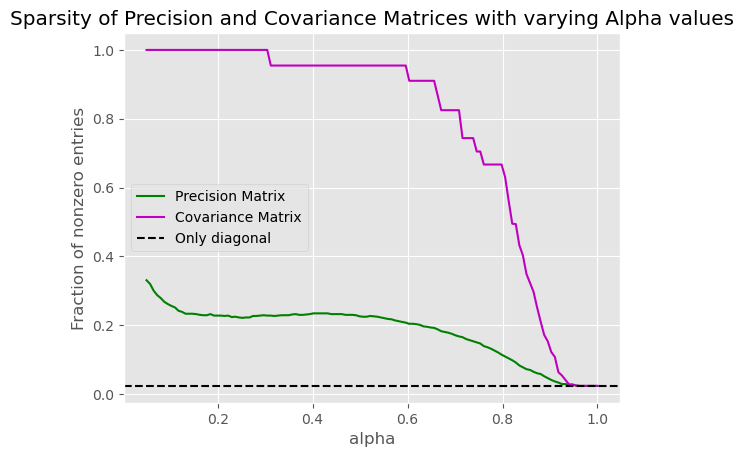

In [10]:
plt.plot(alphas,precision_nonzero/n_features**2,label="Precision Matrix",color="g")
plt.plot(alphas,covariance_nonzero/n_features**2,label="Covariance Matrix",color="m")
plt.xlabel("alpha")
plt.ylabel("Fraction of nonzero entries")
plt.axhline(1/model.covariance_.shape[0],color='k',linestyle='--',label="Only diagonal")
plt.title("Sparsity of Precision and Covariance Matrices with varying Alpha values")
plt.legend()

### Calculate the Bayesian Information Criterion for range of alpha values
- lower BIC is usually better models 
- BIC starts high when alpha is low (less regularized model with more paramters)
- Optimal alpha is where the BIC is minimized (elbow where it starts to decrease sharply)
- So betwee .6-.8 is the best alpha for the model 

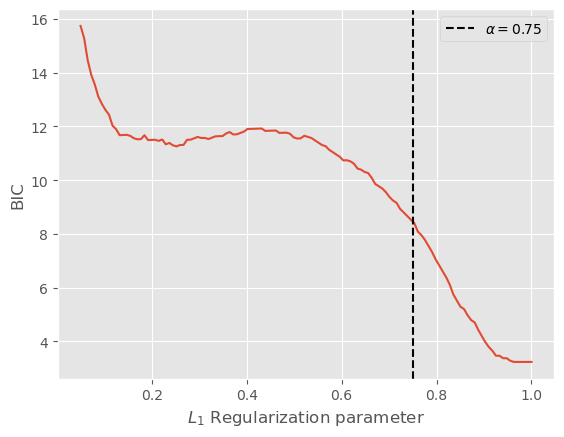

In [11]:
bics = (- 2 * log_likelihoods + ((precision_nonzero - n_features)/2 + n_features) * np.log(n_samples))/n_samples

plt.plot(alphas,bics)
plt.ylabel("BIC")
alpha = 0.75
plt.axvline(alpha,color='k',linestyle='--',label=r"$\alpha="+str(alpha)+"$")
plt.xlabel(r"$L_1$ Regularization parameter")
plt.legend();


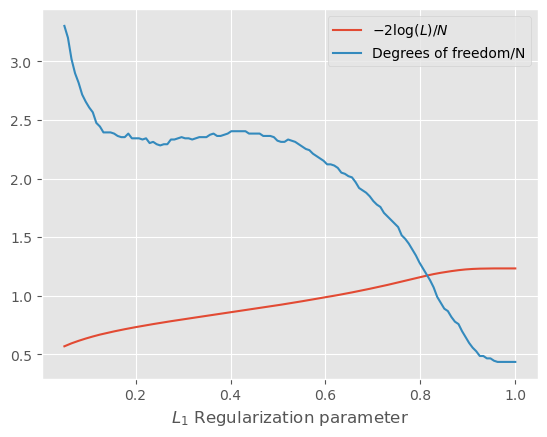

In [12]:
plt.plot(alphas,-2*log_likelihoods/n_samples,label=r'$-2 \log(L)/N$')
plt.plot(alphas,((precision_nonzero - n_features)/2 + n_features)/n_samples,label='Degrees of freedom/N')
plt.legend()
# plt.plot(alphas,bics)
plt.xlabel(r"$L_1$ Regularization parameter");